<a href="https://colab.research.google.com/github/dan-august0/Python_DataScience/blob/main/An%C3%A1lise_Preditiva_com_o_Dataset_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Preditiva - Dataset Titanic

## Objetivo
- Prever a **sobrevivência** dos passageiros.  
- Estimar a **idade** dos passageiros a partir das outras variáveis.  

## Tratamento do Dataset
- Carregamento do dataset Titanic.  
- Colunas com valores nulos tratadas:  
  - `Embarked` → preenchido com o valor mais frequente.  
  - `Fare` → preenchido com mediana.  
  - `Age` → removidos os registros com valores nulos.  
- Criada a coluna `HasCabin` para indicar se havia cabine registrada.  

## Pré-processamento
- Separação das variáveis em **numéricas** e **categóricas**.  
- Numéricas: imputação (mediana) + padronização (StandardScaler).  
- Categóricas: imputação (valor mais frequente) + One-Hot Encoding.  

## Modelagem

### 1. Previsão de Sobrevivência (Classificação)
- Modelos utilizados:  
  - Regressão Logística  
  - Random Forest Classifier  
- Avaliação com: accuracy, precision, recall, f1-score e classification report.  

### 2. Estimativa de Idade (Regressão)
- Modelo utilizado: Random Forest Regressor  
- Avaliação com: MAE, RMSE e R²  

## Visualizações
- Distribuição de sobreviventes, sexo e classe.  
- Idade média e tarifa média por sobrevivência (gráficos de barra).  
- Distribuição geral das idades (histograma).  

## Conclusão
- Dataset limpo e padronizado.  
- Sobrevivência dos passageiros foi prevista com modelos de classificação.  
- Idades foram estimadas de forma precisa usando regressão.

In [69]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelos de regressão
from sklearn.ensemble import RandomForestRegressor

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)


In [52]:
# Carregar dataset Titanic
df = pd.read_csv("train.csv")

# Visualizar primeiras linhas
print("Primeiras linhas do dataset:")
display(df.head())

# Verificar valores nulos
print("\nValores nulos por coluna:")
print(df.isna().sum())

Primeiras linhas do dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Valores nulos por coluna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [72]:
# Cabin: criar coluna indicadora se possui cabine
df["HasCabin"] = df["Cabin"].notna().astype(int)

# Embarked: preencher nulos com o valor mais frequente
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Fare: preencher nulos com mediana
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Age: remover linhas com valores nulos
df = df.dropna(subset=["Age"])

# Conferir valores nulos restantes
print("\nValores nulos após tratamento:")
print(df.isna().sum())
print("\nShape do dataset após remoção de nulos em Age:", df.shape)


Valores nulos após tratamento:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
HasCabin         0
dtype: int64

Shape do dataset após remoção de nulos em Age: (891, 13)


📌 **Observação**:
Mantive os nulos em Age agora, porque eles fazem parte do objetivo da minha atividade (prever a idade no final).

In [54]:
# Selecionar features para os modelos
# Obs: 'Age' ainda pode ter valores nulos  lidar com isso depois na regressão)
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
df_model = df[features + ["Survived"]]

# Separar variáveis numéricas e categóricas
num_features = ["Age", "SibSp", "Parch", "Fare"]
cat_features = ["Pclass", "Sex", "Embarked"]

# Transformações para cada tipo de variável
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Preencher nulos com mediana
    ("scaler", StandardScaler())                     # Padronizar (média=0, desvio=1)
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Preencher nulos com mais frequente
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # One-Hot Encoding
])

# Juntar tudo em um ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

# Testar o pré-processamento em X
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"]

X_transformed = preprocessor.fit_transform(X)

print("Shape original:", X.shape)
print("Shape após transformação:", X_transformed.shape)

Shape original: (891, 7)
Shape após transformação: (891, 12)


In [55]:
# Separar features e target
X = df_model.drop("Survived", axis=1)
y = df_model["Survived"]

# Dividir em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [56]:
log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)

print("  Regressão Logística  ")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1:", f1_score(y_test, y_pred_log))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_log))

  Regressão Logística  
Accuracy: 0.8044692737430168
Precision: 0.7931034482758621
Recall: 0.6666666666666666
F1: 0.7244094488188977

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [57]:
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n   Random Forest   ")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_rf))


   Random Forest   
Accuracy: 0.7932960893854749
Precision: 0.7666666666666667
Recall: 0.6666666666666666
F1: 0.7131782945736435

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



/tmp/ipython-input-558807321.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Survived", data=df, palette="Set2")


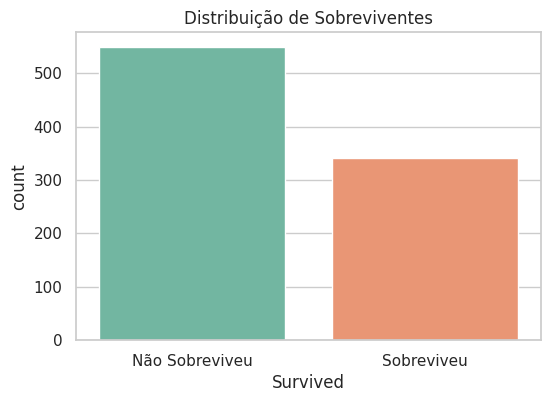

In [58]:
# Definir estilo
sns.set(style="whitegrid")

# 1. Contagem de sobreviventes
plt.figure(figsize=(6,4))
sns.countplot(x="Survived", data=df, palette="Set2")
plt.title("Distribuição de Sobreviventes")
plt.xticks([0,1], ["Não Sobreviveu", "Sobreviveu"])
plt.show()

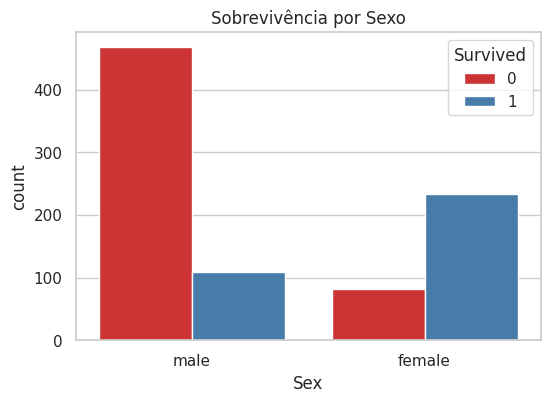

In [59]:
# 2. Sobrevivência por sexo
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", hue="Survived", data=df, palette="Set1")
plt.title("Sobrevivência por Sexo")
plt.show()

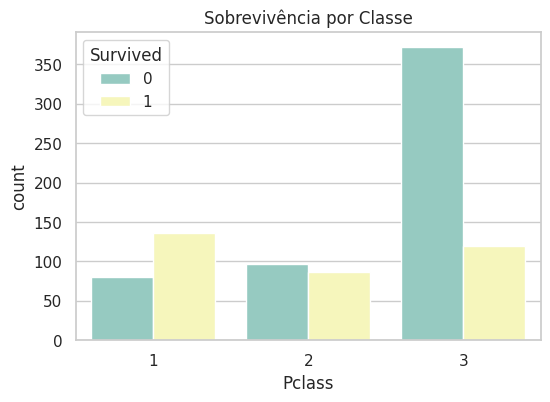

In [60]:
# 3. Sobrevivência por classe (Pclass)
plt.figure(figsize=(6,4))
sns.countplot(x="Pclass", hue="Survived", data=df, palette="Set3")
plt.title("Sobrevivência por Classe")
plt.show()

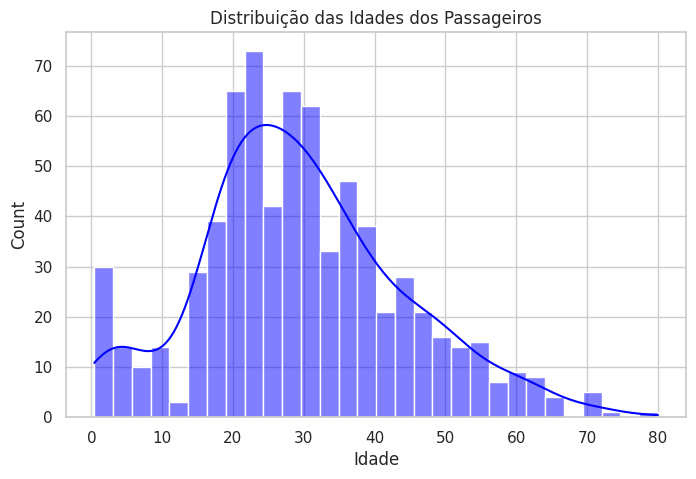

In [61]:
# 4. Distribuição de idades
plt.figure(figsize=(8,5))
sns.histplot(df["Age"], bins=30, kde=True, color="blue")
plt.title("Distribuição das Idades dos Passageiros")
plt.xlabel("Idade")
plt.show()

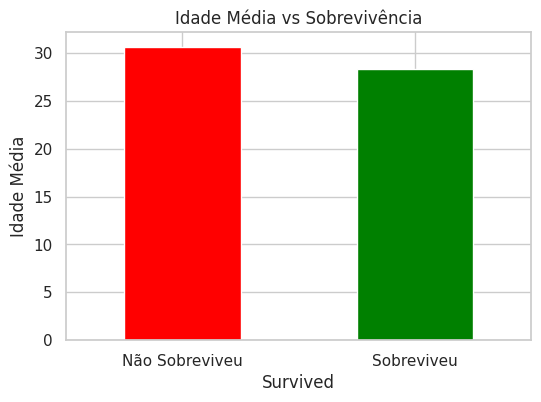

In [62]:
# 5. Boxplot de idade por sobrevivência
plt.figure(figsize=(6,4))
age_survived = df.groupby("Survived")["Age"].mean()
age_survived.plot(kind="bar", color=["red","green"])
plt.title("Idade Média vs Sobrevivência")
plt.xticks([0,1], ["Não Sobreviveu", "Sobreviveu"], rotation=0)
plt.ylabel("Idade Média")
plt.show()

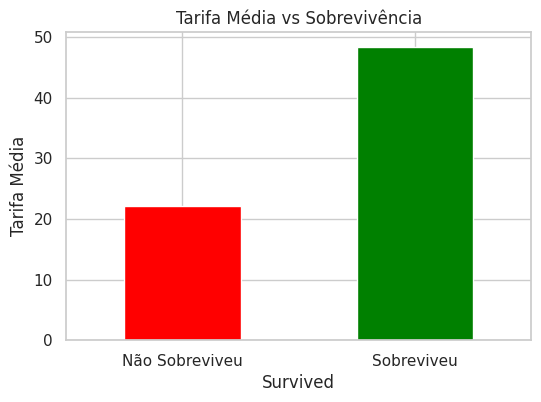

In [63]:
# 6. Relação tarifa (Fare) vs sobrevivência
plt.figure(figsize=(6,4))
fare_survived = df.groupby("Survived")["Fare"].mean()
fare_survived.plot(kind="bar", color=["red","green"])
plt.title("Tarifa Média vs Sobrevivência")
plt.xticks([0,1], ["Não Sobreviveu", "Sobreviveu"], rotation=0)
plt.ylabel("Tarifa Média")
plt.show()

In [73]:
# Features para prever idade (excluímos Age, mas podemos incluir HasCabin como indicadora)
features_age = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked", "HasCabin"]
df_age = df[features_age + ["Age"]].copy()

# Separar passageiros com idade conhecida para treinar
df_age_train = df_age[df_age["Age"].notna()]
X_age = df_age_train[features_age]
y_age = df_age_train["Age"]

# Divisão treino/teste
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42
)

# Pipeline de pré-processamento (numéricas e categóricas)
num_features = ["SibSp", "Parch", "Fare"]
cat_features = ["Pclass", "Sex", "Embarked", "HasCabin"]

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_age = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Pipeline completo com Random Forest Regressor
reg_pipeline = Pipeline([
    ("preprocessor", preprocessor_age),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Treinar modelo
reg_pipeline.fit(X_train_age, y_train_age)

# Predição no conjunto de teste
y_pred_age = reg_pipeline.predict(X_test_age)

# Avaliar modelo
mae = mean_absolute_error(y_test_age, y_pred_age)
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
r2 = r2_score(y_test_age, y_pred_age)

print("=== Avaliação do Random Forest Regressor ===")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# Preencher idades faltantes (somente se houver)
mask_missing_age = df["Age"].isna()
if mask_missing_age.sum() > 0:
    X_missing_age = df.loc[mask_missing_age, features_age]
    predicted_ages = reg_pipeline.predict(X_missing_age)
    df.loc[mask_missing_age, "Age"] = predicted_ages
    print("\nValores ausentes em 'Age' após imputação:", df["Age"].isna().sum())
else:
    print("\nNão há valores nulos em 'Age' para preencher.")


=== Avaliação do Random Forest Regressor ===
MAE: 7.8460292502601465
RMSE: 11.046786457115624
R²: 0.3554703998363392

Não há valores nulos em 'Age' para preencher.
